In [39]:
import os
import datetime
import pytz

import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf

from scipy.signal import find_peaks

In [40]:
def is_gzip_file(filepath):
    with open(filepath, 'rb') as f:
        return f.read(2) == b'\x1f\x8b'
def display_all(df):
    plot_cols = df.columns
    plot_features = df[plot_cols]
    plot_features.index = df.index
    _ = plot_features.plot(subplots=True)

    plot_features = df[plot_cols][:960]
    plot_features.index = df.index[:960]
    _ = plot_features.plot(subplots=True)

In [ ]:
def fill_with_lagged_data(df, periods_back=None):
    """
    Fill missing/zero values with data from specified periods back
    For 15-min data, one year = 365 * 24 * 4 = 35,040 periods
    """
    
    if periods_back is None:
        # Estimate periods for one year based on frequency
        freq = pd.infer_freq(df.index)
        if freq and '15T' in freq:
            periods_back = 365 * 24 * 4  # One year of 15-min data
        elif freq and 'H' in freq:
            periods_back = 365 * 24  # One year of hourly data
        else:
            periods_back = 365  # Default to daily
    
    filled_df = df.copy()
    
    for col in filled_df.columns:
        # Create a shifted version (one year ago)
        lagged_series = filled_df[col].shift(periods_back)
        
        # Create condition: where current value is 0 or NaN
        mask = (filled_df[col].isna()) | (filled_df[col] == 0)
        
        # Fill using the lagged data where the condition is met
        filled_df[col] = filled_df[col].mask(mask, lagged_series)
    
    return filled_df

In [41]:
mpl.rcParams['figure.figsize'] = (10, 6)
mpl.rcParams['axes.grid'] = False
all_cols = ['datetime','current_power','current_value_of_consumption','external_energy_supply','grid_feed_in','internal_power_supply','self_consumption']

In [42]:
csv_path = tf.keras.utils.get_file(
    origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/device-1.csv.tar.gz')
    #origin='https://itsci.mju.ac.th/downloads/watcharin/datasets/pv/export_device_1_basic_aggregated_1hour.csv.gz')
csv_path

'C:\\Users\\ASUS\\.keras\\datasets\\device-1.csv.tar.gz'

In [43]:
if is_gzip_file(csv_path):
  # Read the data directly into a pandas DataFrame
  df = pd.read_csv(csv_path, compression='gzip')
else:
  # Read the data without compression
  df = pd.read_csv(csv_path)

row_count = df.shape[0]
print(f"Total rows: {row_count}")
df.head(5)

Total rows: 138239


,device-1.csv,ambient_temperature,current_power,current_value_of_consumption,external_energy_supply,grid_feed_in,internal_power_supply,self_consumption,temperature_measurement,total_irradiation
0,2021-11-06 11:15:00,30.288889,46519.355556,37280.422222,NaN,9238.933333,37280.422222,37280.422222,58.022222,798.444444
1,2021-11-06 11:30:00,30.076923,47600.714286,39472.626374,NaN,9397.756098,39132.406593,39132.406593,58.263736,812.571429
2,2021-11-06 11:45:00,30.629213,47056.988764,32669.393258,NaN,14387.595506,32669.393258,32669.393258,57.235955,807.224719
3,2021-11-06 12:00:00,31.021978,48415.835165,36126.516484,NaN,12289.318681,36126.516484,36126.516484,56.846154,817.527473
4,2021-11-06 12:15:00,31.831461,49345.404494,36879.966292,NaN,12465.438202,36879.966292,36879.966292,55.842697,816.651685


In [44]:
# Rename the first column to 'new_name'
df = df.rename(columns={df.columns[0]: 'datetime'})

In [45]:
try:
    df['datetime'] = pd.to_datetime(df['datetime'])
    print("✅ แปลง Datetime สำเร็จด้วย pd.to_datetime() แบบอัตโนมัติ")
except Exception as e:
    print(f"❌ การแปลงแบบอัตโนมัติล้มเหลว: {e}")
    try:
        df['datetime'] = pd.to_datetime(df['datetime'], format='%Y-%m-%d %H:%M:%S')
        print("✅ แปลง Datetime สำเร็จด้วย format '%Y-%m-%d %H:%M:%S'")
    except Exception as e2:
        print(f"❌ การแปลงด้วย format ล้มเหลว: {e2}")
        # ใช้วิธีสุดท้าย - แปลงแบบ errors='coerce'
        df['datetime'] = pd.to_datetime(df['datetime'], errors='coerce')
        print("⚠️  แปลง Datetime ด้วย errors='coerce' (ค่าที่แปลงไม่ได้จะเป็น NaT)")

✅ แปลง Datetime สำเร็จด้วย pd.to_datetime() แบบอัตโนมัติ


In [46]:
df = df.sort_values('datetime').reset_index(drop=True)

In [47]:
# Convert 'timestamp' column to datetime
df = df.set_index('datetime')

print(df.index.year.unique())
print(df.index.year.value_counts())

Index([2021.0, 2022.0, 2023.0, 2024.0, 2025.0, nan], dtype='float64', name='datetime')
datetime
2024.0    35136
2023.0    35040
2022.0    35040
2025.0    27691
2021.0     5331
Name: count, dtype: int64


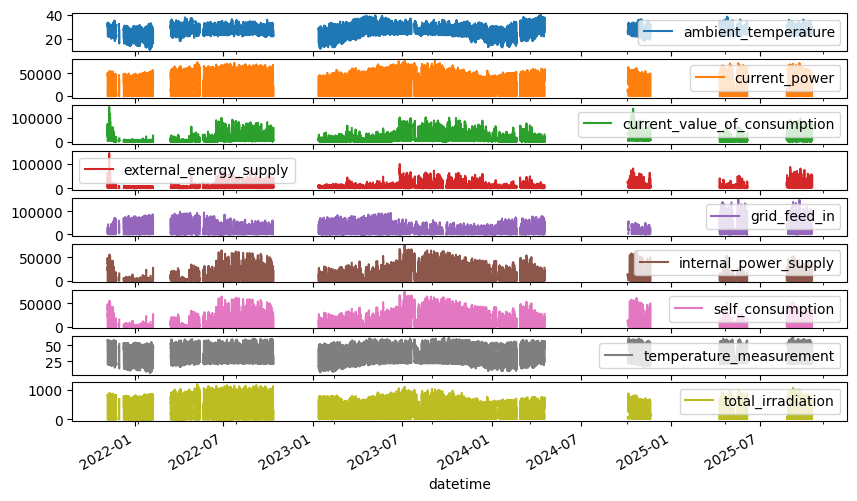

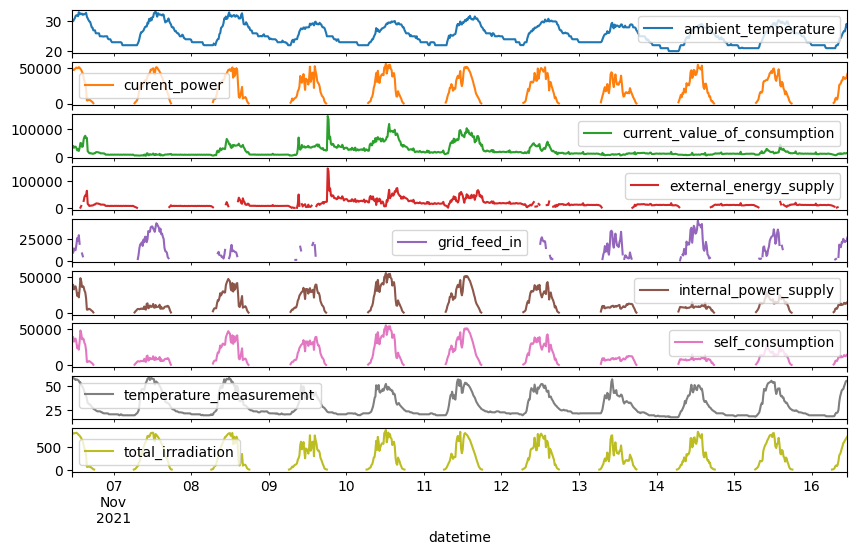

In [48]:
display_all(df)

In [49]:
print("\nจำนวน Missing Values ก่อนทำการ fill:")
for col in df.columns:
    if col in df.columns:
        missing_count = df[col].isnull().sum()
        if missing_count > 0:
            print(f"  {col}: {missing_count} missing values")


จำนวน Missing Values ก่อนทำการ fill:
  ambient_temperature: 58139 missing values
  current_power: 98436 missing values
  current_value_of_consumption: 67185 missing values
  external_energy_supply: 84507 missing values
  grid_feed_in: 112625 missing values
  internal_power_supply: 107094 missing values
  self_consumption: 107094 missing values
  temperature_measurement: 58139 missing values
  total_irradiation: 101948 missing values


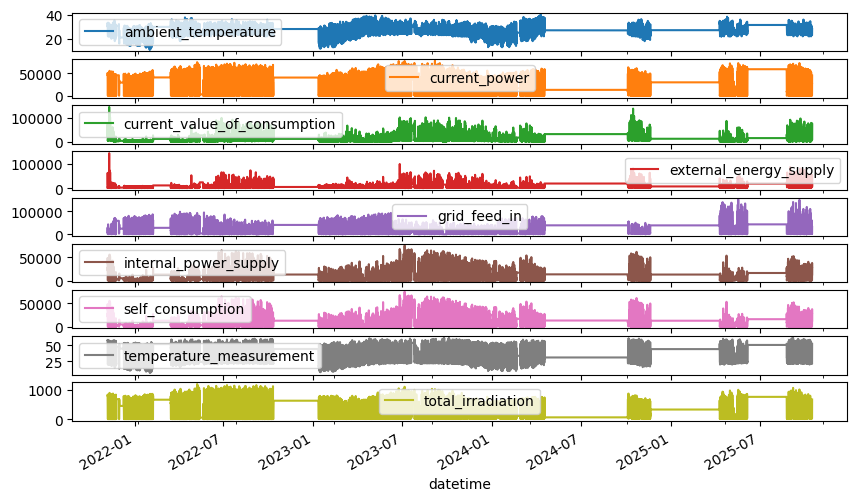

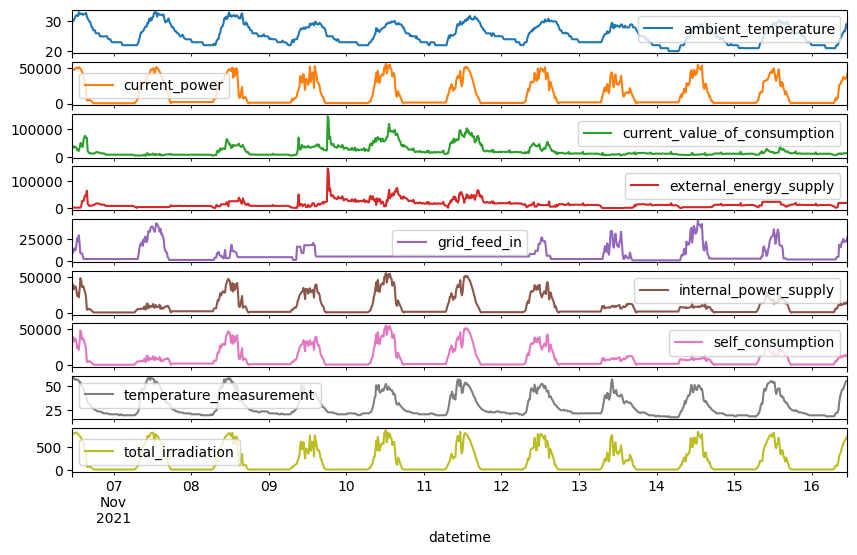

In [38]:
# For 15-minute data, one day = 96 points, one year ≈ 35,040 points
limit_value = 35040  # approximately one year of 15-minute data

for col in df.columns:
    df[col] = df[col].bfill(limit=limit_value)
    
display_all(df)

Text(0, 0.5, 'Current Power')

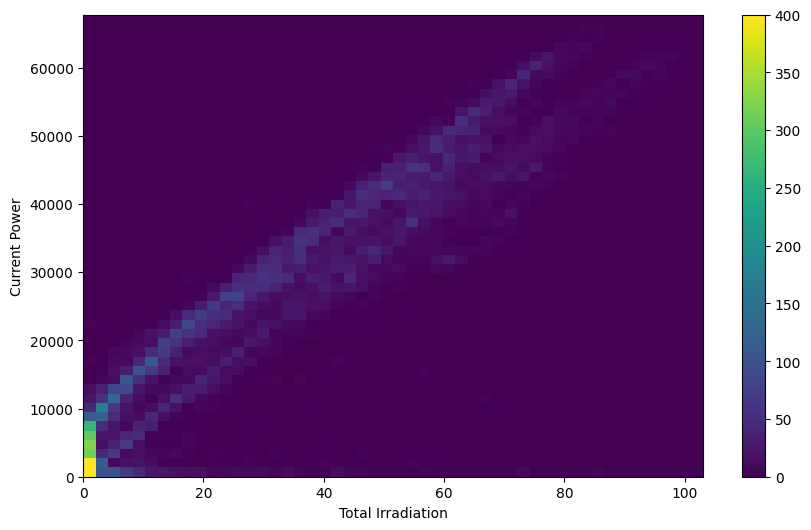

In [18]:
plt.hist2d(df['Total Irradiation'], df['Current Power'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Total Irradiation')
plt.ylabel('Current Power')

Text(0, 0.5, 'Current Power')

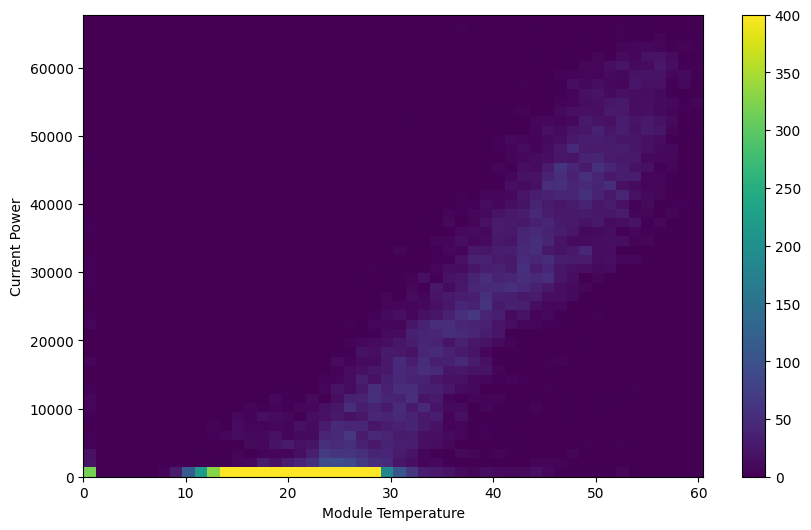

In [19]:
plt.hist2d(df['Module Temperature'], df['Current Power'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Module Temperature')
plt.ylabel('Current Power')

Text(0, 0.5, 'Self Consumption')

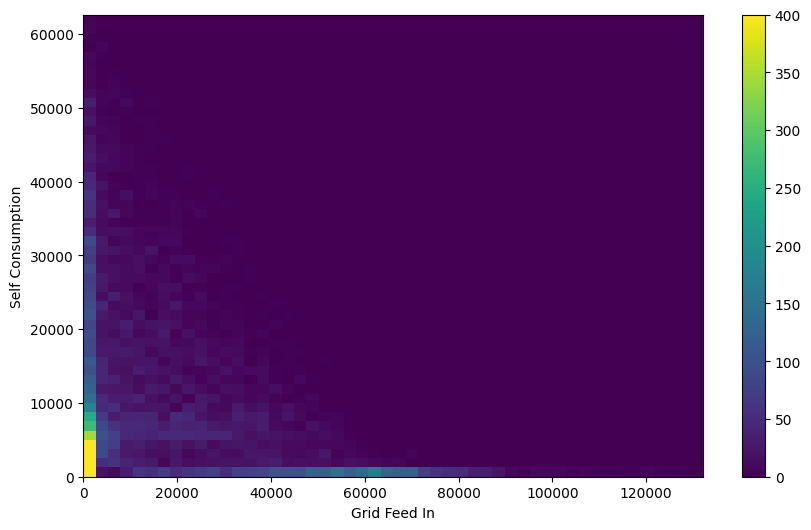

In [20]:
plt.hist2d(df['Grid Feed In'], df['Self Consumption'], bins=(50, 50), vmax=400)
plt.colorbar()
plt.xlabel('Grid Feed In')
plt.ylabel('Self Consumption')

In [21]:
timestamp_s = df.index.map(pd.Timestamp.timestamp)
timestamp_s

Index([1636196400.0, 1636200000.0, 1636203600.0, 1636207200.0, 1636210800.0,
       1636214400.0, 1636218000.0, 1636221600.0, 1636225200.0, 1636228800.0,
       ...
       1749146400.0, 1749150000.0, 1749153600.0, 1749157200.0, 1749160800.0,
       1749164400.0, 1749168000.0, 1749171600.0, 1749175200.0, 1749178800.0],
      dtype='float64', name='Datetime', length=31385)

In [22]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Grid Feed In,31385.0,8513.892997,17306.132993,0.0,0.000000,0.000000,7387.200000,132140.307692
External Energy Supply,31385.0,5938.457118,6018.065186,0.0,86.555256,6511.200000,8088.000000,95312.861538
Internal Power Supply,31385.0,5306.420075,9876.661539,0.0,0.000000,0.000000,6280.751282,62600.441860
Current Power,31385.0,12654.937194,17547.187468,0.0,0.000000,309.200000,24822.541026,67764.166667
Self Consumption,31385.0,5306.420075,9876.661539,0.0,0.000000,0.000000,6280.751282,62600.441860
Ambient Temperature,31385.0,25.658336,5.448226,0.0,23.150000,25.766667,29.190000,39.510909
Module Temperature,31385.0,29.565478,11.917668,0.0,21.855224,25.453590,38.455952,60.466667
Total Irradiation,31385.0,15.520645,23.581650,0.0,0.000000,0.002051,27.515090,103.062660


In [23]:
day = 24*60*60
year = (365.2425)*day
df['Day sin'] = np.sin(timestamp_s * (2 * np.pi / day))
df['Day cos'] = np.cos(timestamp_s * (2 * np.pi / day))
df['Year sin'] = np.sin(timestamp_s * (2 * np.pi / year))
df['Year cos'] = np.cos(timestamp_s * (2 * np.pi / year))

Total data points 31385
Total data points in a day 96.0


Text(0.5, 1.0, 'Time of day signal')

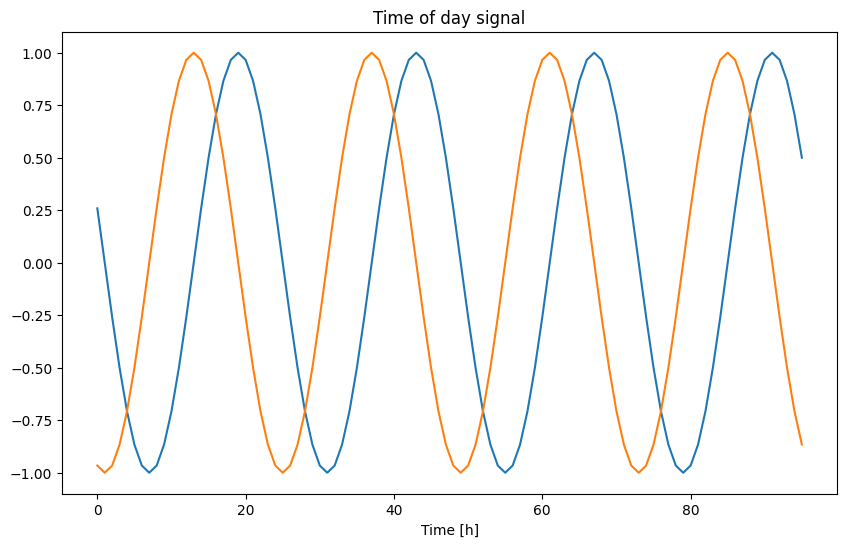

In [24]:
print(f"Total data points {len(df)}")
print(f"Total data points in a day {24*60/15}")

plt.plot(np.array(df['Day sin'])[:96])
plt.plot(np.array(df['Day cos'])[:96])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [25]:
def manual_rfftfreq(n_samples, d):
    """
    Manual implementation of np.fft.rfftfreq()
    
    Parameters:
    n_samples (int): Number of samples in the original time domain signal
    d (float): Sample spacing (time between samples) in seconds
    
    Returns:
    numpy array: Array of frequencies corresponding to FFT output
    """
    # Calculate the sample rate (samples per second)
    sample_rate = 1.0 / d
    
    # For real FFT, we get n//2 + 1 frequency bins (including DC component)
    num_freq_bins = n_samples // 2 + 1
    
    # Calculate frequency increment between bins
    freq_increment = sample_rate / n_samples
    
    # Generate frequencies from 0 to Nyquist frequency
    frequencies = np.arange(num_freq_bins) * freq_increment
    
    return frequencies

# Example usage:
n_samples = len(df['Current Power'])
sample_period = 15 * 60  # 15 minutes in seconds

# Manual calculation
manual_frequencies = manual_rfftfreq(n_samples, sample_period)
manual_frequencies[-1]

np.float64(0.0005555378542474289)

In [26]:
# Verify against NumPy's implementation
numpy_frequencies = np.fft.rfftfreq(n_samples, d=sample_period)

# Compare the first few values
print("Manual calculation:", manual_frequencies[:5])
print("NumPy calculation :", numpy_frequencies[:5])

Manual calculation: [0.00000000e+00 3.54026163e-08 7.08052325e-08 1.06207849e-07
 1.41610465e-07]
NumPy calculation : [0.00000000e+00 3.54026163e-08 7.08052325e-08 1.06207849e-07
 1.41610465e-07]


In [27]:
# Find peaks manually
def find_peaks_manual(x, min_prominence_ratio=0.01):
    peaks = []
    for i in range(1, len(x)-1):
        if x[i] > x[i-1] and x[i] > x[i+1]:
            peaks.append(i)

    print(peaks)
    
    max_val = x.max()
    threshold = max_val * min_prominence_ratio
    peaks = [p for p in peaks if x[p] > threshold]
    
    return np.array(peaks)

In [28]:
fft = tf.signal.rfft(df['Current Power'])
max_val = np.abs(fft).max()
f_per_dataset = np.arange(0, len(fft))
years_per_dataset = n_samples/(sample_period)

f_per_year = f_per_dataset/years_per_dataset

In [29]:
# Get amplitude spectrum
amplitude_spectrum = np.abs(fft.numpy())  # Convert to NumPy array

# Find the peaks
peaks = find_peaks_manual(amplitude_spectrum)
# Convert peak indices to frequencies
peak_frequencies = f_per_year[peaks]

[4, 7, 11, 13, 15, 18, 21, 25, 28, 32, 36, 39, 43, 47, 50, 54, 57, 60, 63, 69, 71, 75, 78, 80, 82, 86, 89, 91, 93, 97, 99, 103, 107, 109, 111, 115, 118, 122, 125, 128, 132, 136, 138, 142, 145, 147, 150, 154, 157, 161, 164, 168, 172, 178, 180, 182, 184, 190, 193, 196, 202, 204, 208, 210, 216, 218, 220, 222, 225, 228, 231, 233, 237, 241, 243, 247, 250, 252, 254, 256, 258, 260, 262, 265, 269, 273, 275, 279, 282, 284, 286, 288, 290, 297, 300, 304, 306, 309, 314, 318, 320, 323, 325, 327, 329, 334, 336, 338, 340, 344, 347, 351, 353, 355, 357, 360, 362, 366, 368, 372, 376, 379, 382, 384, 386, 391, 393, 396, 399, 403, 405, 407, 409, 411, 413, 415, 417, 422, 426, 429, 431, 435, 437, 439, 441, 444, 449, 451, 454, 456, 460, 463, 470, 472, 476, 480, 482, 484, 487, 492, 494, 500, 502, 505, 507, 512, 516, 519, 521, 526, 528, 531, 533, 535, 537, 540, 544, 546, 551, 554, 559, 561, 565, 567, 569, 573, 575, 581, 586, 589, 592, 595, 598, 601, 603, 609, 611, 615, 619, 622, 624, 626, 628, 630, 633, 638, 64

In [30]:
# Convert frequencies to periods
peak_periods = 1 / peak_frequencies

# Sort peaks by amplitude
sorted_indices = np.argsort(-amplitude_spectrum[peaks])
peaks = peaks[sorted_indices]
peak_frequencies = peak_frequencies[sorted_indices]
peak_periods = peak_periods[sorted_indices]

# Show results (top 5 peaks)
for i, (freq, period) in enumerate(zip(peak_frequencies[:5], peak_periods[:5])):
    print(f"Peak {i+1}: Frequency = {freq:.4f} cycles/year")
    
    # Convert to more intuitive units
    days = period * 365.25
    if days < 1:
        print(f"    Period ≈ {days*24:.2f} hours")
    elif days < 30:
        print(f"    Period ≈ {days:.2f} days")
    else:
        print(f"    Period ≈ {period*12:.2f} months")

Peak 1: Frequency = 37.5084 cycles/year
    Period ≈ 9.74 days
Peak 2: Frequency = 74.9881 cycles/year
    Period ≈ 4.87 days
Peak 3: Frequency = 37.5944 cycles/year
    Period ≈ 9.72 days
Peak 4: Frequency = 112.4964 cycles/year
    Period ≈ 3.25 days
Peak 5: Frequency = 75.1028 cycles/year
    Period ≈ 4.86 days


Text(0.5, 1.0, 'Frequency Spectrum of Current Power with Peak Frequencies')

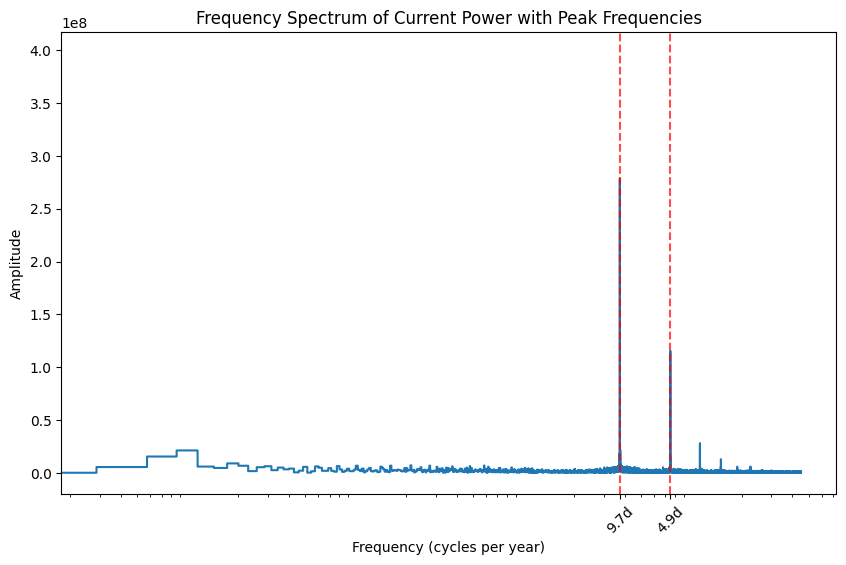

In [31]:
# Get top peaks (assuming you've already calculated them)
top_peaks = peak_frequencies[:2]  # Top 3 peaks

# Create frequency ticks including standard references and top peaks
#tick_locations = [1, 12, 52, 365.2524]  # Standard references (year, month, week, day)
tick_locations = []
tick_locations.extend(top_peaks)  # Add peak frequencies
tick_locations.sort()  # Sort them in ascending order

# Create corresponding labels
tick_labels = []
for freq in tick_locations:
    if abs(freq - 1) < 0.1:
        tick_labels.append('1/Year')
    elif abs(freq - 12) < 0.5:
        tick_labels.append('1/Month')
    elif abs(freq - 52) < 2:
        tick_labels.append('1/Week')
    elif abs(freq - 365.2524) < 10:
        tick_labels.append('1/Day')
    else:
        period_days = (1/freq) * 365.2524
        if period_days < 1:
            tick_labels.append(f'{period_days*24:.1f}h')
        else:
            tick_labels.append(f'{period_days:.1f}d')

plt.step(f_per_year, np.abs(fft))
plt.xscale('log')

# Apply the customized ticks to your plot
plt.xticks(tick_locations, labels=tick_labels, rotation=45)

# Add a vertical line at each peak for emphasis
for freq in top_peaks:
    plt.axvline(x=freq, color='r', linestyle='--', alpha=0.7)

plt.xlabel('Frequency (cycles per year)')
plt.ylabel('Amplitude')
plt.title('Frequency Spectrum of Current Power with Peak Frequencies')

In [32]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

In [33]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

[Text(0, 0, 'Grid Feed In'),
 Text(1, 0, 'External Energy Supply'),
 Text(2, 0, 'Internal Power Supply'),
 Text(3, 0, 'Current Power'),
 Text(4, 0, 'Self Consumption'),
 Text(5, 0, 'Ambient Temperature'),
 Text(6, 0, 'Module Temperature'),
 Text(7, 0, 'Total Irradiation'),
 Text(8, 0, 'is_weekend'),
 Text(9, 0, 'Day sin'),
 Text(10, 0, 'Day cos'),
 Text(11, 0, 'Year sin'),
 Text(12, 0, 'Year cos')]

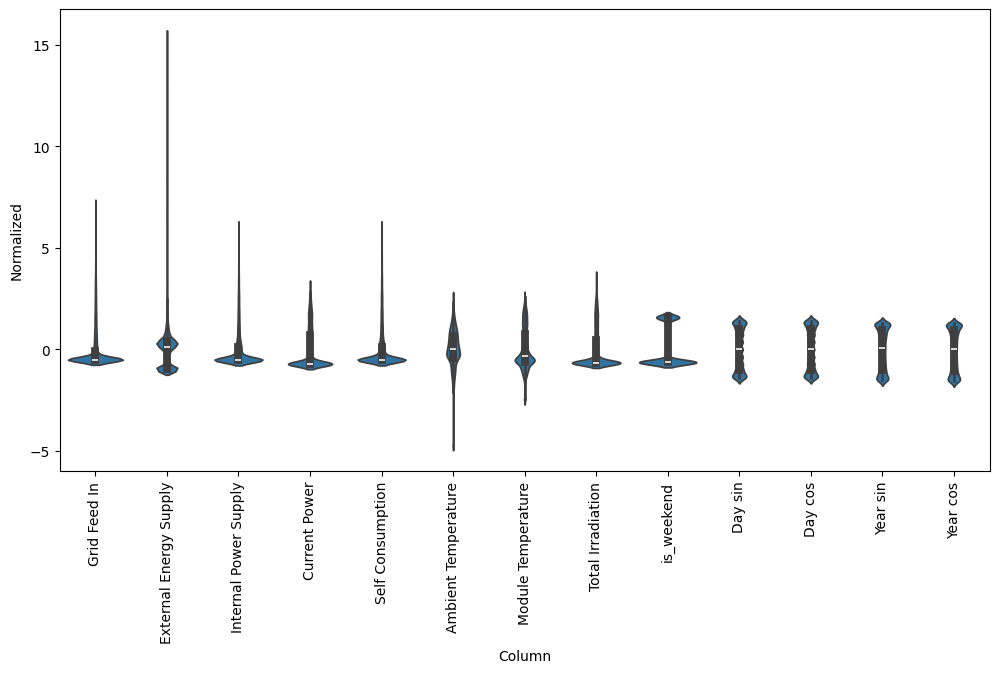

In [34]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
ax.set_xticks(range(len(df.keys())))
ax.set_xticklabels(df.keys(), rotation=90)

In [35]:
class WindowGenerator():
  def __init__(self, input_width, label_width, shift,
               train_df=train_df, val_df=val_df, test_df=test_df,
               label_columns=None):
    # Store the raw data.
    self.train_df = train_df
    self.val_df = val_df
    self.test_df = test_df

    # Work out the label column indices.
    self.label_columns = label_columns
    if label_columns is not None:
      self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
    self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

    # Work out the window parameters.
    self.input_width = input_width
    self.label_width = label_width
    self.shift = shift

    self.total_window_size = input_width + shift

    self.input_slice = slice(0, input_width)
    self.input_indices = np.arange(self.total_window_size)[self.input_slice]

    self.label_start = self.total_window_size - self.label_width
    self.labels_slice = slice(self.label_start, None)
    self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

  def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if self.label_columns is not None:
      labels = tf.stack([labels[:, :, self.column_indices[name]] for name in self.label_columns], axis=-1)

    # Slicing doesn't preserve static shape information, so set the shapes
    # manually. This way the `tf.data.Datasets` are easier to inspect.
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

  def plot(self, model=None, plot_col='Current Power', max_subplots=3):
    inputs, labels = self.example
    plt.figure(figsize=(12, 8))
    plot_col_index = self.column_indices[plot_col]
    max_n = min(max_subplots, len(inputs))
    for n in range(max_n):
      plt.subplot(max_n, 1, n+1)
      plt.ylabel(f'{plot_col} [normed]')
      plt.plot(self.input_indices, inputs[n, :, plot_col_index], label='Inputs', marker='.', zorder=-10)

      if self.label_columns:
        label_col_index = self.label_columns_indices.get(plot_col, None)
      else:
        label_col_index = plot_col_index

      if label_col_index is None:
        continue

      plt.scatter(self.label_indices, labels[n, :, label_col_index], edgecolors='k', label='Labels', c='#2ca02c', s=64)
        
      if model is not None:
        predictions = model(inputs)
        plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                    marker='X', edgecolors='k', label='Predictions', c='#ff7f0e', s=64)

      if n == 0:
        plt.legend()

    plt.xlabel('Time [15min]')

  def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data,
        targets=None,
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)

    ds = ds.map(self.split_window)

    return ds
    
  @property
  def train(self):
    return self.make_dataset(self.train_df)

  @property
  def val(self):
    return self.make_dataset(self.val_df)

  @property
  def test(self):
    return self.make_dataset(self.test_df)

  @property
  def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if result is None:
      # No example batch was found, so get one from the `.train` dataset
      result = next(iter(self.train))
      # And cache it for next time
      self._example = result
    return result
  
  def __repr__(self):
    return '\n'.join([
        f'Total window size: {self.total_window_size}',
        f'Input indices: {self.input_indices}',
        f'Label indices: {self.label_indices}',
        f'Label column name(s): {self.label_columns}'])

In [36]:
single_step_window = WindowGenerator(
    input_width=1, label_width=1, shift=1,
    label_columns=['Current Power'])
single_step_window

Total window size: 2
Input indices: [0]
Label indices: [1]
Label column name(s): ['Current Power']

In [37]:
wide_window = WindowGenerator(
    input_width=24, label_width=24, shift=1,
    label_columns=['Current Power'])

wide_window

Total window size: 25
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
Label indices: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24]
Label column name(s): ['Current Power']

In [38]:
linear = tf.keras.Sequential([
    tf.keras.layers.Dense(units=1)
])

In [39]:
print('Input shape:', single_step_window.example[0].shape)
print('Output shape:', linear(single_step_window.example[0]).shape)

Input shape: (32, 1, 13)
Output shape: (32, 1, 1)


In [40]:
MAX_EPOCHS = 20

def compile_and_fit(model, window, patience=2):
  early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                    patience=patience,
                                                    mode='min')

  model.compile(loss=tf.keras.losses.MeanSquaredError(),
                optimizer=tf.keras.optimizers.Adam(),
                metrics=[tf.keras.metrics.MeanAbsoluteError()])

  history = model.fit(window.train, epochs=MAX_EPOCHS,
                      validation_data=window.val,
                      callbacks=[early_stopping])
  return history

In [41]:
val_performance = {}
performance = {}

history = compile_and_fit(linear, single_step_window)

val_performance['Linear'] = linear.evaluate(single_step_window.val, return_dict=True)
performance['Linear'] = linear.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.7905 - mean_absolute_error: 0.6612 - val_loss: 0.2451 - val_mean_absolute_error: 0.3741
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1619 - mean_absolute_error: 0.2975 - val_loss: 0.1415 - val_mean_absolute_error: 0.2721
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1283 - mean_absolute_error: 0.2587 - val_loss: 0.1342 - val_mean_absolute_error: 0.2607
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1236 - mean_absolute_error: 0.2517 - val_loss: 0.1320 - val_mean_absolute_error: 0.2566
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1212 - mean_absolute_error: 0.2479 - val_loss: 0.1303 - val_mean_absolute_error: 0.2539
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1194 - mean_absolute_error: 0.2454 - val_loss: 0.1298 - val_mean_absolute_error: 0.2524
Epoch 7/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 0.1185 - mean_absolute_error: 0.2435 - v

In [42]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', linear(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


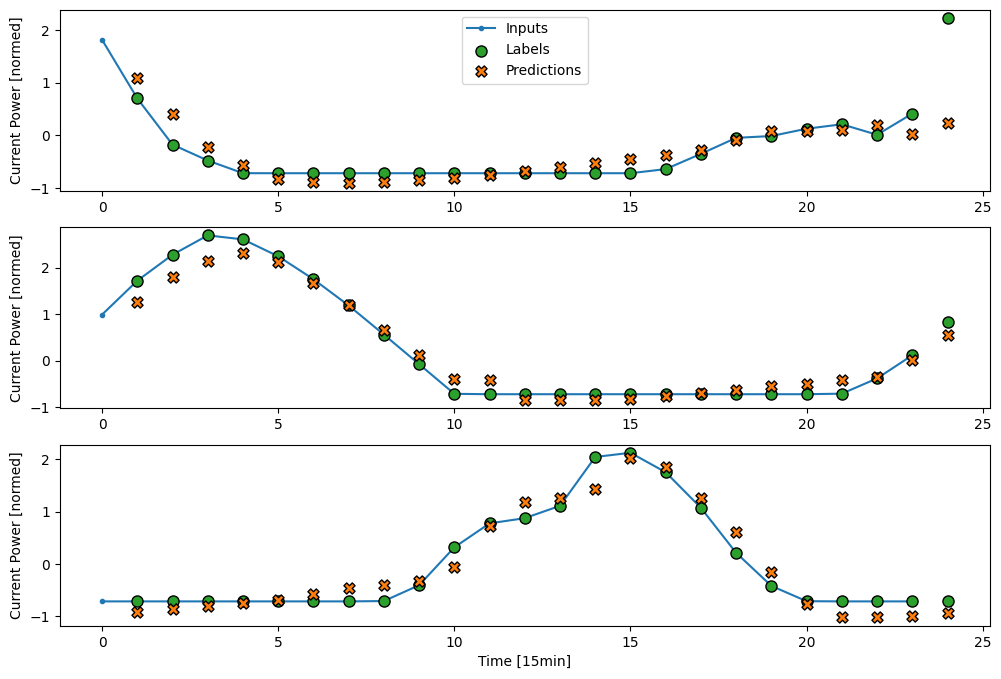

In [43]:
wide_window.plot(linear)

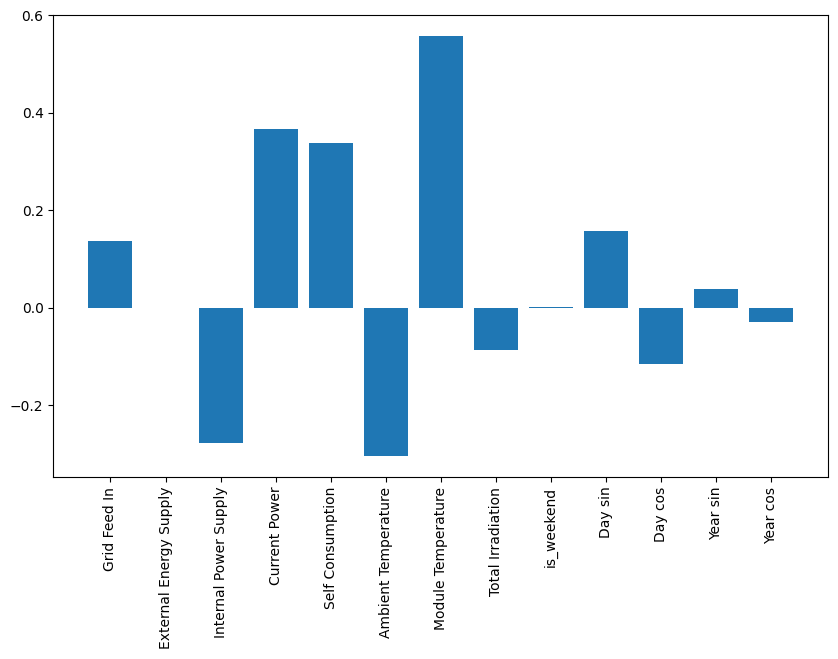

In [44]:
plt.bar(x = range(len(train_df.columns)),
        height=linear.layers[0].kernel[:,0].numpy())
axis = plt.gca()
axis.set_xticks(range(len(train_df.columns)))
_ = axis.set_xticklabels(train_df.columns, rotation=90)

In [45]:
dense = tf.keras.Sequential([
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=64, activation='relu'),
    tf.keras.layers.Dense(units=1)
])

history = compile_and_fit(dense, single_step_window)

val_performance['Dense'] = dense.evaluate(single_step_window.val, return_dict=True)
performance['Dense'] = dense.evaluate(single_step_window.test, verbose=0, return_dict=True)

Epoch 1/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.1088 - mean_absolute_error: 0.1818 - val_loss: 0.0921 - val_mean_absolute_error: 0.1669
Epoch 2/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0784 - mean_absolute_error: 0.1451 - val_loss: 0.0924 - val_mean_absolute_error: 0.1664
Epoch 3/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0754 - mean_absolute_error: 0.1398 - val_loss: 0.0878 - val_mean_absolute_error: 0.1615
Epoch 4/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0747 - mean_absolute_error: 0.1387 - val_loss: 0.0871 - val_mean_absolute_error: 0.1705
Epoch 5/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0727 - mean_absolute_error: 0.1357 - val_loss: 0.0862 - val_mean_absolute_error: 0.1531
Epoch 6/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0719 - mean_absolute_error: 0.1339 - val_loss: 0.0865 - val_mean_absolute_error: 0.1528
Epoch 7/20
687/687 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0715 - mean_absolute_error: 0.1330 - v

In [46]:
CONV_WIDTH = 3
conv_window = WindowGenerator(
    input_width=CONV_WIDTH,
    label_width=1,
    shift=1,
    label_columns=['Current Power'])

conv_window

Total window size: 4
Input indices: [0 1 2]
Label indices: [3]
Label column name(s): ['Current Power']

Text(0.5, 0.98, 'Given 3 hours of inputs, predict 1 hour into the future.')

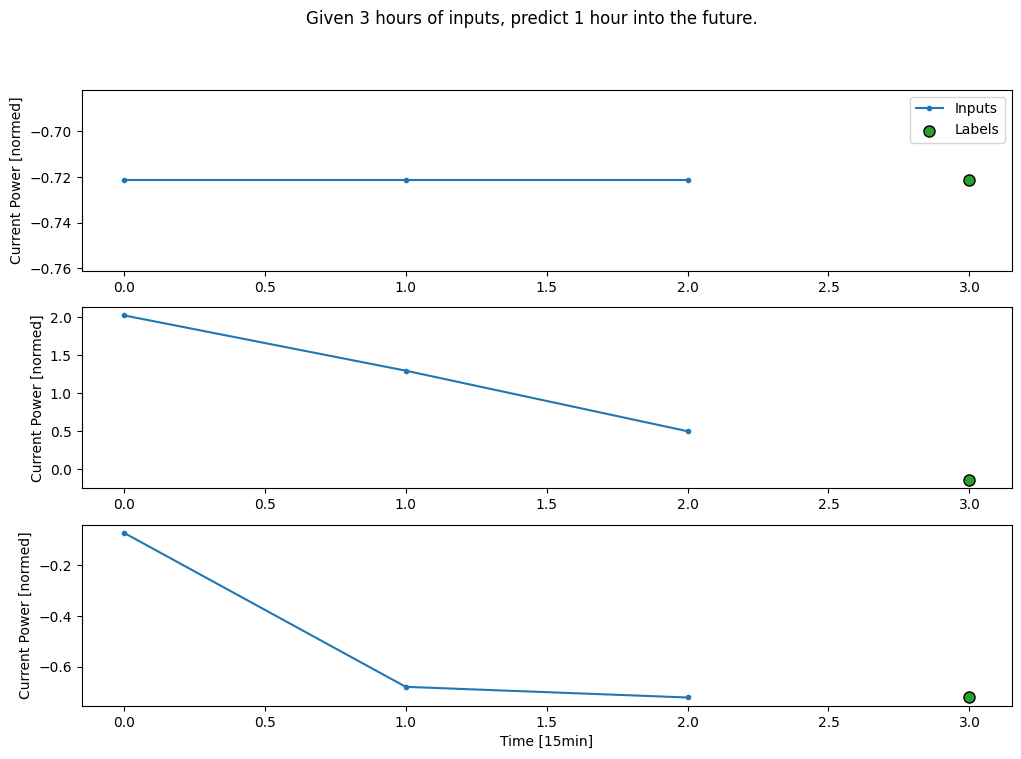

In [47]:
conv_window.plot()
plt.suptitle("Given 3 hours of inputs, predict 1 hour into the future.")

In [48]:
multi_step_dense = tf.keras.Sequential([
    # Shape: (time, features) => (time*features)
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
    # Add back the time dimension.
    # Shape: (outputs) => (1, outputs)
    tf.keras.layers.Reshape([1, -1]),
])

In [49]:
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', multi_step_dense(conv_window.example[0]).shape)

Input shape: (32, 3, 13)
Output shape: (32, 1, 1)


In [50]:
history = compile_and_fit(multi_step_dense, conv_window)

IPython.display.clear_output()
val_performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.val, return_dict=True)
performance['Multi step dense'] = multi_step_dense.evaluate(conv_window.test, verbose=0, return_dict=True)

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0852 - mean_absolute_error: 0.1650  


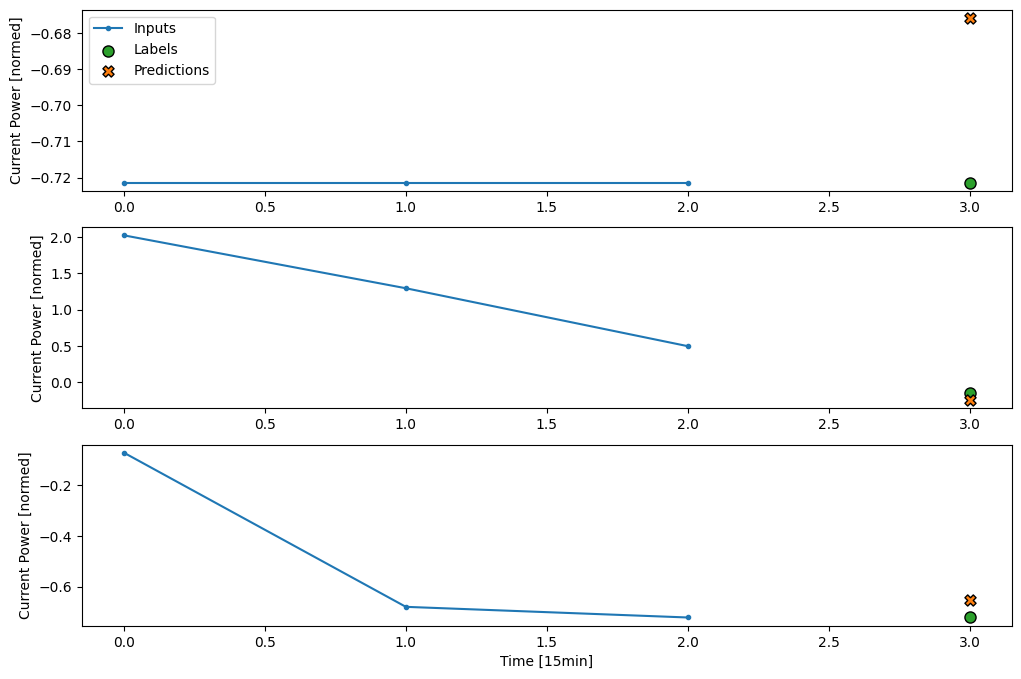

In [51]:
conv_window.plot(multi_step_dense)

In [52]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(CONV_WIDTH,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Dense(units=1),
])

In [53]:
print("Conv model on `conv_window`")
print('Input shape:', conv_window.example[0].shape)
print('Output shape:', conv_model(conv_window.example[0]).shape)

Conv model on `conv_window`
Input shape: (32, 3, 13)
Output shape: (32, 1, 1)


In [54]:
history = compile_and_fit(conv_model, conv_window)

IPython.display.clear_output()
val_performance['Conv'] = conv_model.evaluate(conv_window.val, return_dict=True)
performance['Conv'] = conv_model.evaluate(conv_window.test, verbose=0, return_dict=True)

197/197 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.0804 - mean_absolute_error: 0.1459


In [55]:
print("Wide window")
print('Input shape:', wide_window.example[0].shape)
print('Labels shape:', wide_window.example[1].shape)
print('Output shape:', conv_model(wide_window.example[0]).shape)

Wide window
Input shape: (32, 24, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 22, 1)


In [56]:
LABEL_WIDTH = 24
INPUT_WIDTH = LABEL_WIDTH + (CONV_WIDTH - 1)
wide_conv_window = WindowGenerator(
    input_width=INPUT_WIDTH,
    label_width=LABEL_WIDTH,
    shift=1,
    label_columns=['Current Power'])

wide_conv_window

Total window size: 27
Input indices: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Label indices: [ 3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26]
Label column name(s): ['Current Power']

In [57]:
print("Wide conv window")
print('Input shape:', wide_conv_window.example[0].shape)
print('Labels shape:', wide_conv_window.example[1].shape)
print('Output shape:', conv_model(wide_conv_window.example[0]).shape)

Wide conv window
Input shape: (32, 26, 13)
Labels shape: (32, 24, 1)
Output shape: (32, 24, 1)


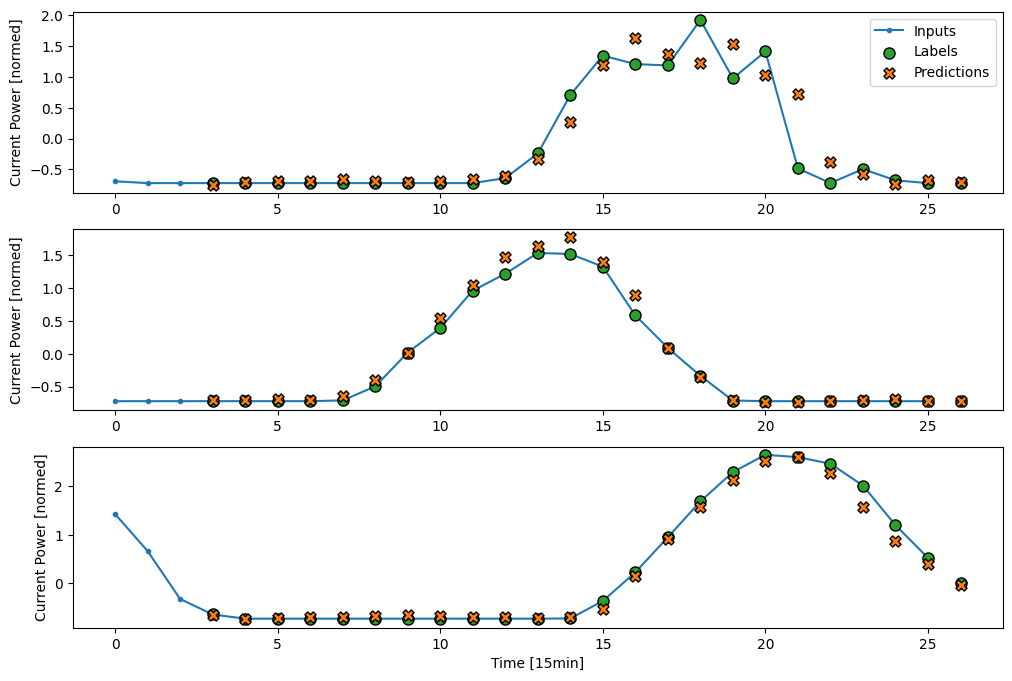

In [58]:
wide_conv_window.plot(conv_model)

In [59]:
lstm_model = tf.keras.models.Sequential([
    # Shape [batch, time, features] => [batch, time, lstm_units]
    tf.keras.layers.LSTM(32, return_sequences=True),
    # Shape => [batch, time, features]
    tf.keras.layers.Dense(units=1)
])

In [60]:
print('Input shape:', wide_window.example[0].shape)
print('Output shape:', lstm_model(wide_window.example[0]).shape)

Input shape: (32, 24, 13)
Output shape: (32, 24, 1)


In [61]:
history = compile_and_fit(lstm_model, wide_window)

Epoch 1/20
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1476 - mean_absolute_error: 0.2203 - val_loss: 0.0906 - val_mean_absolute_error: 0.1660
Epoch 2/20
686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0743 - mean_absolute_error: 0.1377 - val_loss: 0.0836 - val_mean_absolute_error: 0.1511
Epoch 3/20
686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0698 - mean_absolute_error: 0.1281 - val_loss: 0.0810 - val_mean_absolute_error: 0.1451
Epoch 4/20
686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0673 - mean_absolute_error: 0.1238 - val_loss: 0.0800 - val_mean_absolute_error: 0.1426
Epoch 5/20
686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0651 - mean_absolute_error: 0.1215 - val_loss: 0.0806 - val_mean_absolute_error: 0.1452
Epoch 6/20
686/686 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0629 - mean_absolute_error: 0.1196 - val_loss: 0.0796 - val_mean_absolute_error: 0.1434
Epoch 7/20
686/686 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0606 - mean_absolute_error: 0.1175 - v

In [62]:
IPython.display.clear_output()
val_performance['LSTM'] = lstm_model.evaluate(wide_window.val, return_dict=True)
performance['LSTM'] = lstm_model.evaluate(wide_window.test, verbose=0, return_dict=True)

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step - loss: 0.0800 - mean_absolute_error: 0.1424


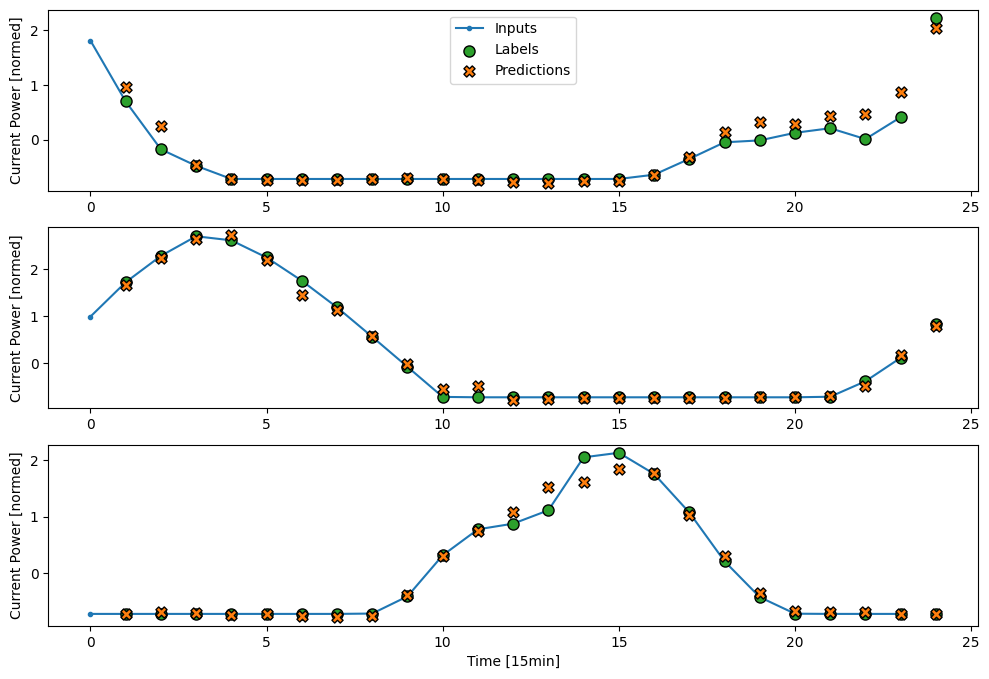

In [63]:
wide_window.plot(lstm_model)

In [64]:
class ResidualWrapper(tf.keras.Model):
  def __init__(self, model):
    super().__init__()
    self.model = model

  def call(self, inputs, *args, **kwargs):
    delta = self.model(inputs, *args, **kwargs)

    # The prediction for each time step is the input
    # from the previous time step plus the delta
    # calculated by the model.
    return inputs + delta

In [65]:
%%time
residual_lstm = ResidualWrapper(
    tf.keras.Sequential([
    tf.keras.layers.LSTM(32, return_sequences=True),
    tf.keras.layers.Dense(
        num_features,
        # The predicted deltas should start small.
        # Therefore, initialize the output layer with zeros.
        kernel_initializer=tf.initializers.zeros())
]))

history = compile_and_fit(residual_lstm, wide_window)

IPython.display.clear_output()
val_performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.val, return_dict=True)
performance['Residual LSTM'] = residual_lstm.evaluate(wide_window.test, verbose=0, return_dict=True)
print()

196/196 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.0761 - mean_absolute_error: 0.1470

CPU times: total: 4min 12s
Wall time: 1min 34s


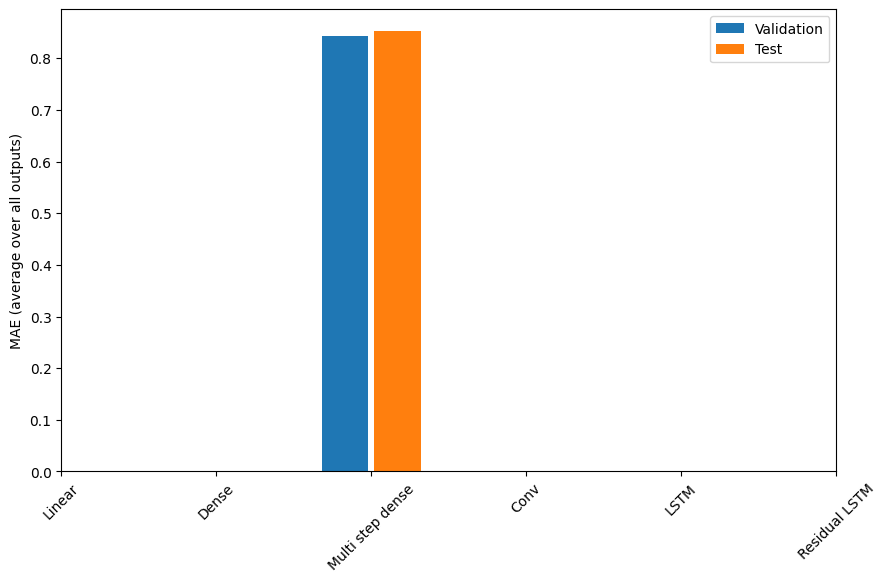

In [56]:
x = np.arange(len(performance))
width = 0.3

metric_name = 'mean_absolute_error'
val_mae = [v[metric_name] for v in val_performance.values()]
test_mae = [v[metric_name] for v in performance.values()]

plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
plt.ylabel('MAE (average over all outputs)')
_ = plt.legend()